# Tiling Satellite Images

## 1. Install and Import Required Packages

In [ ]:
%%capture
!pip install -U rasterio geopandas fastai

In [ ]:
# Import packages
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
from shapely.ops import unary_union # previously used: cascaded_union
from shapely.geometry import mapping, Point, Polygon
import numpy as np
from PIL import Image
import os
from fastai.vision.all import *
from tqdm import tqdm
import cv2

## 2. Set Paths for Images and Masks

If running on Google Colab, uncomment the next cell and mount Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set directory containing images retrieve a list of all images contained.
image_path = Path(f"/content/drive/MyDrive/UNITAC/satellite_imagery/Managua_NIC/1040010087B10F00/016043245010_01_003/016043245010_01_003/016043245010_01/016043245010_01_P001_MUL/23JUN25161448-M3DS_R2C3-016043245010_01_P001.TIF")
# images_list = get_image_files(path/"test_image")

# Set directory of shapefile to be used to create mask
# shp_path = f"{path}/label_directory/your_labels.shp"

## 3. Define Functions

This next function does the same but only for image files (it will not tile the corresponding mask). Set single = False for multiple images.

In [ ]:
BAND_STRUCTURE = ["coastal", "blue", "green", "yellow", "red", "red-edge", "near-IR1", "near-IR2"]

def get_band(image_path, band_name):
  band_idx = BAND_STRUCTURE.index(band_name) + 1

  with rasterio.open(f"{image_path}") as infile:
      img = infile.read(band_idx)

  return img

bands = []

for band in BAND_STRUCTURE:
    bands.append(get_band(image_path, band))

rgb_image = np.stack((bands[4], bands[2], bands[1]), axis=-1)

In [ ]:
#@title Tile img function
def tile_img(rgb_image, output_path, tile_size: int, single = None):
  """Tile image into smaller tiles and save them"""
  if single == False:
    for fn in tqdm(image_path):
      # Create directory
      if not os.path.exists(output_path):
        os.makedirs(output_path)

      # Load image as numpy array and retrieve its shape
      x, y, _ = rgb_image.shape

      # Cut image into tiles and store them as .png-files
      for i in range(x//tile_size):
        for j in range(y//tile_size):
          img_tile = rgb_image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
          Image.fromarray(img_tile).save(f'{output_path}/{fn.name[:-4]}/{fn.name[:-4]}_{i}_{j}.png')

  if single == True:
    # Create directory
    if not os.path.exists(output_path):
      os.makedirs(output_path)

    x, y, _ = rgb_image.shape

    # Cut image into tiles and store them as .png-files
    fn = image_path.name[:-4]

        # Create a subdirectory for the image tiles
    image_tile_dir = os.path.join(output_path, fn)
    if not os.path.exists(image_tile_dir):
        os.makedirs(image_tile_dir)

    for i in range(x//tile_size):
      for j in range(y//tile_size):
        img_tile = rgb_image[i*tile_size:(i+1)*tile_size, j*tile_size:(j+1)*tile_size]
        Image.fromarray(img_tile).save(f'{image_tile_dir}/{fn}_{i}_{j}.png')

And here we tile the images and masks for training.

In [ ]:
# Tile images and masks with a stride of 0 pixels
tile_size = 512
output_path = "/content/drive/MyDrive/UNITAC/satellite_imagery/image_tiles"
tile_img(rgb_image, output_path, tile_size, single=True)

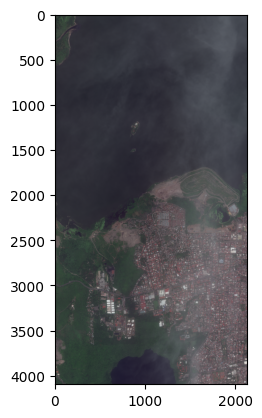

In [ ]:
plt.imshow(rgb_image)
plt.show()

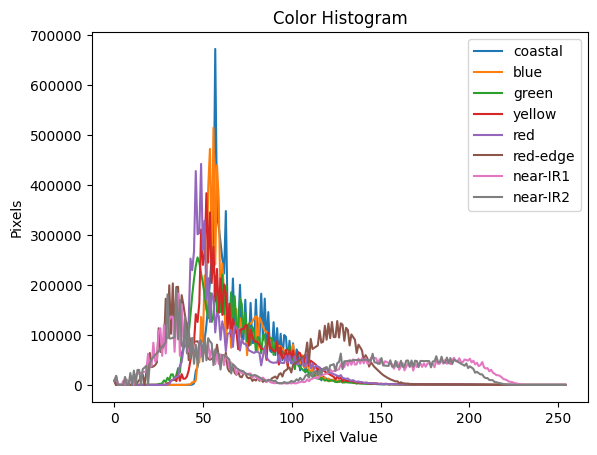

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Assuming rgb_image is your image
for i, color in enumerate(BAND_STRUCTURE):
    histogram, bin_edges = np.histogram(
        mul_image[:, :, i], bins=256, range=(0, 255)
    )
    plt.plot(bin_edges[0:-1], histogram)

plt.title("Color Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Pixels")
plt.legend(BAND_STRUCTURE)
plt.show()
